# TM07 word2vec vs doc2vec

- [【資料分析概念大全｜認識文本分析】Word2Vec, Doc2Vec 比較 (附Python程式碼)](https://medium.com/datamixcontent-lab/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90%E5%B8%AB%E8%87%AA%E5%AD%B8%E7%AD%86%E8%A8%98-%E6%A6%82%E5%BF%B5-%E5%AF%A6%E4%BD%9C%E7%AF%87-%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%E5%85%A5%E9%96%80-%E4%B9%8B-word2vec-doc2vec-%E6%AF%94%E8%BC%83-c94dd0a407c7)

## Loading data

In [30]:
!mkdir ./data
!wget -P ./data -N https://github.com/p4css/py4css/raw/main/data/sentiment.csv

mkdir: ./data: File exists
--2022-11-22 11:45:15--  https://github.com/p4css/py4css/raw/main/data/sentiment.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/p4css/py4css/main/data/sentiment.csv [following]
--2022-11-22 11:45:16--  https://raw.githubusercontent.com/p4css/py4css/main/data/sentiment.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 558978 (546K) [text/plain]
Saving to: './data/sentiment.csv'

sentiment.csv       100%[===================>] 545.88K  2.53MB/s    in 0.2s    

Last-modified header missing -- time-stamps turned off.
2022-11-22 11:45:16 (2.53 MB/s) - './data/sentim

In [31]:
import pandas as pd
df = pd.read_csv('data/sentiment.csv')
df.head(5)

,tag,text
0,P,店家很給力，快遞也是相當快，第三次光顧啦
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。
2,P,不錯，在同等檔次酒店中應該是值得推薦的！
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字


### Tokenization

In [32]:
import jieba
df['token_text'] = df['text'].apply(lambda x:list(jieba.cut(x)))
df.head()

,tag,text,token_text
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]"
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]"
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]"
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是..."


## Training w2v

In [6]:
from gensim.models import Word2Vec
w2v = Word2Vec(df['token_text'], min_count=1, vector_size=300, window=10, sg=0, workers=4)

### Representsd by w2v

In [9]:
import numpy as np

all_list = []
for i, tokens in enumerate(df["token_text"]):
    temp_w2v = np.zeros(300)
    for tok in tokens:
        temp_w2v += w2v.wv[tok]
    all_list.append(temp_w2v)
    
X = np.array(all_list)

## Training doc2vec

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

### Represented by TaggedDocument

In [33]:
tagged = [TaggedDocument(words=tokens, tags=[i]) 
          for i, tokens in enumerate(df["token_text"])]

### Training model

In [34]:
d2v = Doc2Vec(tagged, vector_size=100, alpha=0.025, window=5,
              min_alpha=0.00025, min_count=5, dm=1)
    # dm=1 : ‘distributed memory’ (PV-DM) ; 
    # dm=0 : ‘distributed bag of words’ (PV-DBOW)

d2v.train(tagged, total_examples=d2v.corpus_count, epochs=20)

### Represented by d2v

In [35]:
import numpy as np

all_list = []
for i, tokens in enumerate(df["token_text"]):
    all_list.append(d2v.infer_vector(tokens))
    
X = np.array(all_list)

In [36]:
X.shape

(6388, 100)

## Plotting

### Reduced by umap

In [26]:
# !pip install umap-learn
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(X)

### Clustering by HDBSCAN

In [27]:
# !pip install hdbscan
import hdbscan
from collections import Counter

cluster = hdbscan.HDBSCAN(min_cluster_size= 50,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

df['cluster'] = list(cluster.labels_)
print(df.columns)
print(Counter(df['cluster']))

Index(['tag', 'text', 'token_text', 'cluster'], dtype='object')
Counter({0: 5635, 2: 329, -1: 309, 1: 115})


### Plotting

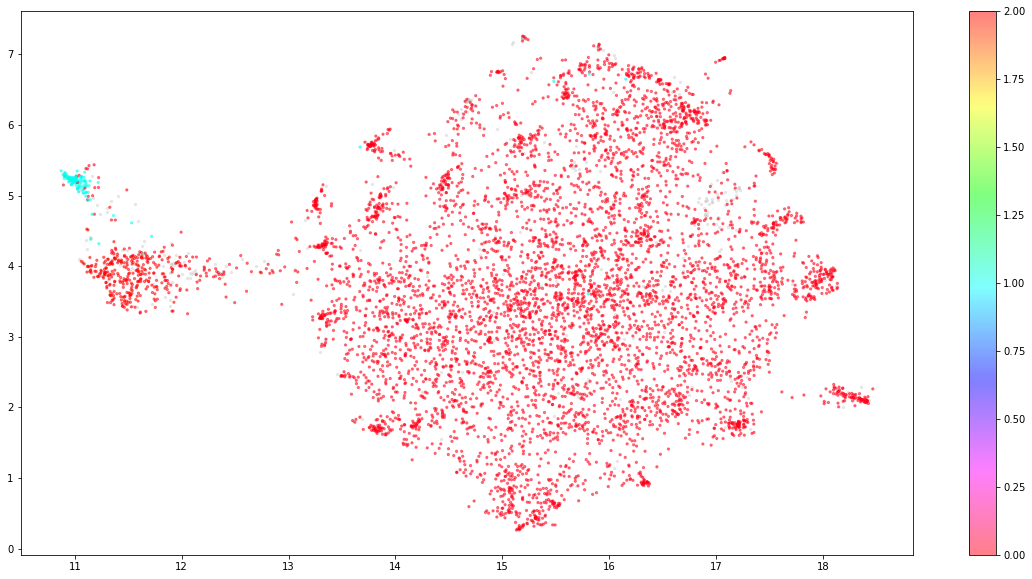

In [37]:
import matplotlib.pyplot as plt

umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(X)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5, alpha=0.3)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, alpha=0.5, cmap='hsv_r')
plt.colorbar()